In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras import backend as K
from keras.layers import Layer, Lambda
print(tf.__version__)
tf.autograph.set_verbosity(0) # trace warning off

2.17.0


Import Pascal model

In [2]:
pascal_model = keras.models.load_model('pascal_model.keras')
inputData = np.zeros(pascal_model.output_shape[1:])
inputData[0,0,0] = 1
inputData = inputData[np.newaxis,:,:,:]
inputData =  tf.convert_to_tensor(inputData, dtype=tf.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


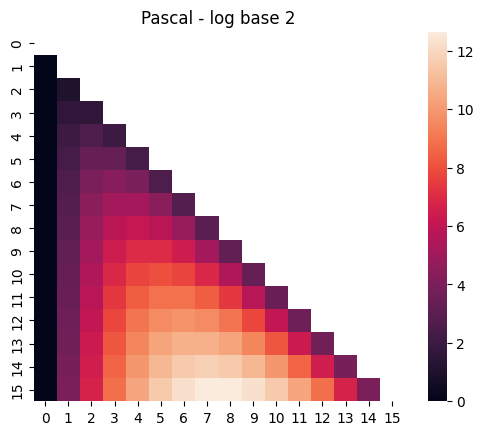

In [3]:
p = np.squeeze( pascal_model.predict(inputData) )
mask = np.zeros_like(p)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(np.log2(np.maximum(p,np.finfo(float).eps)), mask=mask, square=True,)
plt.title("Pascal - log base 2")
plt.show()

Create radial basis activation used in indexing operations

In [4]:
def radbas(n, epsil=1):
    """ activate strongly when input=0. epsilon is shape param """
    n = tf.convert_to_tensor(n, dtype=tf.float32)
    epsil = tf.convert_to_tensor(epsil, dtype=tf.float32)
    result = keras.ops.exp(-(n*epsil)**2)
    return result

def exponent_layer(x, exponent):
    """ used for exponentiating to a power"""
    
    y = keras.ops.power(x, exponent)
    return y

In [5]:
unit_in = -np.ones((1,1,1))
unit_in =  tf.convert_to_tensor(unit_in, dtype=tf.float32)

idx_in = np.ones((1,1,1))
idx_in =  tf.convert_to_tensor(idx_in, dtype=tf.float32)

Layers below are so we can index specific columns of Pascal as required

In [6]:
num_pascal = pascal_model.output_shape[1]
weights = np.eye(num_pascal).reshape(num_pascal,1,1,num_pascal)
bias = np.zeros(num_pascal,)
w = [weights,bias]

unit_input_layer = layers.Input(shape=(1,1,1),name="unit_in")
# tile
tile = Lambda(keras.backend.tile, arguments={'n':(1, num_pascal, 1, 1)})(unit_input_layer)
# removed from pad: input_shape=(num_pascal,1)
pad = layers.ZeroPadding2D(
            padding=((num_pascal-1,0),(0,0)), 
            data_format='channels_last')(tile)
v_cumsum_layer = layers.Conv2D(num_pascal, (num_pascal, 1), activation=None, padding="valid",
                            trainable=False)
v_cumsum = v_cumsum_layer(pad)
v_cumsum_layer.set_weights(w)

idx_input_layer = layers.Input(shape=(1,1,1),name="idx_in")
# tile. Use (1,num_pascal,1,1) for row index
tile_idx = Lambda(keras.backend.tile, arguments={'n':(1, num_pascal, 1, 1)})(idx_input_layer)
# Sum up outputs from cumsum model, which gives us linear indexes
sum_axis3 = layers.Conv2D(1, (1, 1), activation=None, padding="valid")
sumaxis_out = sum_axis3(v_cumsum)
sum_axis3.set_weights([np.ones((1,1,num_pascal,1)),np.ones(1,)])

# Combine models
mergedOut = layers.Add(name="index_match")([sumaxis_out,tile_idx])
radbas_idx = Lambda(radbas,arguments={'epsil':10})(mergedOut)

output_pascal = layers.Multiply()([radbas_idx, pascal_model.output])


Prepare 'exponent arrays' used for building string labels with correct coefficients

In [7]:
print(f"Pascal size: {num_pascal}")
exponent_lookupA = np.ones((num_pascal,num_pascal))
exponent_lookupA = np.tril(exponent_lookupA,-1) 

exponent_lookupB = np.ones((num_pascal,num_pascal))
exponent_lookupB = np.tril(exponent_lookupB)
exponent_lookupB[:,0] = 0

exponent_lookupA = np.cumsum(exponent_lookupA[:,::-1],axis=1)[:,::-1]
exponent_lookupB = np.cumsum(exponent_lookupB,axis=1) * exponent_lookupB

Pascal size: 16


Build the full model including Pascal module and indexer

In [8]:
A_in = np.ones((1,1))
B_in = np.ones((1,1))
A_in =  tf.convert_to_tensor(A_in, dtype=tf.float32)
B_in =  tf.convert_to_tensor(B_in, dtype=tf.float32)

A_input_layer = layers.Input(shape=(1,1),name="A_in")
B_input_layer = layers.Input(shape=(1,1),name="B_in")

A = Lambda(exponent_layer, arguments={'exponent': exponent_lookupA} )(A_input_layer)
B = Lambda(exponent_layer, arguments={'exponent': exponent_lookupB} )(B_input_layer)
merged_exponent = layers.Multiply()([A,B])
# pool axis 3 merely removes a singleton dimension from 4D array, to allow correct broadcasting in multiply
pool_axis3 = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=False))(output_pascal)
# multiply with the output layer noted earlier
final_out = layers.Multiply()([pool_axis3, merged_exponent])
maxpool_out = Lambda(lambda x: tf.reduce_max(x, axis=1, keepdims=False))(final_out)
minpool_out = Lambda(lambda x: tf.reduce_min(x, axis=1, keepdims=False))(final_out)
final_out = layers.Add(name="final_add")([maxpool_out, minpool_out])

In [9]:
# full model combining aspects discussed prior
pascal_full_model = keras.Model(inputs=[
    unit_input_layer, idx_input_layer, pascal_model.input, A_input_layer, B_input_layer], outputs=final_out)
pascal_full_model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=[tf.keras.metrics.BinaryAccuracy(),
         tf.keras.metrics.FalseNegatives(),
         tf.keras.metrics.FalsePositives()],
)
pascal_full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_12   │ (None, 17, 17, 1) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_13   │ (None, 17, 17, 1) │          0 │ conv2d_12[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_14   │ (None, 17, 17, 1) │          0 │ conv2d_13[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_15   │ (None, 17, 17, 1) │          0 │ conv2d_14[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_16   │ (None, 17, 17, 1) │          0 │ conv2d_15[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_17   │ (None, 17, 17, 1) │          0 │ conv2d_16[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_18   │ (None, 17, 17, 1) │          0 │ conv2d_17[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_19   │ (None, 17, 17, 1) │          0 │ conv2d_18[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 17, 17, 1) │          0 │ conv2d_19[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16, 1) │          5 │ zero_padding2d_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 17, 17, 1) │          0 │ conv2d_20[0][0] 

 Total params: 369 (1.44 KB)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 352 (1.38 KB)

Let's now generate a dataset for testing (Ax + By)^n with sympy library.

In [10]:
x = sym.Symbol('x')
y = sym.Symbol('y')

In [ ]:
def range_excluding(start, stop, exclude=0):
    return [np.r_[start:exclude, exclude+1:stop]]

def make_binomials_factored_and_expanded(coeff_range=8, power_range=8, x=x, y=y):
    """ 
    Generate deterministic sweep of binomials
    Ignore special case 0 which isn't really a binomial coefficient
    Ignore special cases 0 and 1 exponent which isn't really a binomial
    """

    x_coeff = np.repeat( np.tile( range_excluding(-coeff_range,coeff_range+1), 2*coeff_range), power_range-1)
    y_coeff = np.repeat( np.repeat( range_excluding(-coeff_range,coeff_range+1), 2*coeff_range), power_range-1)
    binom_power = np.tile( np.tile( np.arange(2,power_range+1), 2*coeff_range), 2*coeff_range )
    
    eq = []
    fact_eq = []
    for i in range((2*coeff_range)**2 * (power_range-1)):
        factored_e = (x_coeff[i]*x + y_coeff[i]*y) ** binom_power[i]

        fact_eq.append(str(factored_e))
        e = sym.expand(factored_e)
        eq.append( e )
        
    return eq, fact_eq, x_coeff, y_coeff, binom_power


eq, fact_eq, x_coeff, y_coeff, binom_power = make_binomials_factored_and_expanded(coeff_range=8, power_range=8)

In [12]:
coeff_dict_list = [e.as_coefficients_dict() for e in eq]
YTest = np.zeros((len(eq), 1, num_pascal))

for idx in range(len(eq)):
    L = len(coeff_dict_list[idx].values())
    for j in range(L):
        YTest[idx, :, j] = coeff_dict_list[idx][ x**(L-j-1) * y**j]

We now test accuracy, and the time taken with timeit.

Note, we have to ensure YTest is cast to np.float32, or else float precision will display small error in spite of being the same integers (note - the AI model outputs float32 but YPred is float64)

In [13]:
def eval_model_bcast(YTest, showResult):
    YPred = pascal_full_model.predict([
        unit_in * np.ones((len(eq),1,1)),
        idx_in*binom_power[:,np.newaxis,np.newaxis],
        inputData* np.ones((len(eq),1,1,1)),
        x_coeff[:,np.newaxis]*A_in,
        y_coeff[:,np.newaxis]*B_in])
    if showResult:
        print(f" YPred shape {np.shape(YPred)}")
        print(f" YTest shape {np.shape(YTest)}")
        accu = np.mean(YPred[:,np.newaxis,:].astype('int') == np.float32(YTest.astype('int')))
        print(f"Accuracy: {100* accu}%")
        return YPred
# show result       
YPred = eval_model_bcast(YTest, showResult=True)
print(f"Num samples: {len(eq)}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 YPred shape (1792, 16)
 YTest shape (1792, 1, 16)
Accuracy: 100.0%
Num samples: 1792


Repeat results to show an average of inference time

In [14]:
import timeit
timeit.timeit("eval_model_bcast(YTest, showResult=False)", setup="from __main__ import eval_model_bcast, YTest", number=100)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━

29.183878500014544

Show the first output of YPred as a sting in easily readable format

In [15]:
print(f"When model inputs are ({x_coeff[0]} + {y_coeff[0]})^{binom_power[0]}")

## make labels correspond per row of triangle
def output_labels(row):
    labs = []
    for idx in range(num_pascal):
        xco = exponent_lookupA[row, idx]
        yco = exponent_lookupB[row, idx]
        xstr, ystr = '',''
        if xco >1:
            xstr = 'x^'+str(int(xco))
        elif xco == 1:
            xstr = 'x'
        if yco >1:
            ystr = 'y^'+str(int(yco))
        elif yco == 1:
            ystr = 'y'
        labs.append(xstr+ystr)
    return labs

print(f"YPred 1st sample: {YPred[0]}")
print(f"YPred 1st sample: {YTest[0]}")

labs = output_labels(binom_power[0])
s = ""
for idx, l in enumerate(YPred[0]):    
    if YPred[0][idx] != 0:
        if idx>0:
            s += " + "
        s += str(int(YPred[0][idx])) + labs[idx]

print(f"String result is: {s}")

When model inputs are (-8 + -8)^2
YPred 1st sample: [ 64. 128.  64.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.]
YPred 1st sample: [[ 64. 128.  64.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]]
String result is: 64x^2 + 128xy + 64y^2


Bonus Material.

Show that we could also have indexed columns of Pascal, to extract for example simplex numbers

In [16]:
num_pascal = pascal_model.output_shape[1]
weights = np.eye(num_pascal).reshape(1,num_pascal,1,num_pascal)
bias = np.zeros(num_pascal,)
w = [weights,bias]

unit_input_layer = layers.Input(shape=(1,1,1),name="unit_in")
# tile
tile = Lambda(keras.backend.tile, arguments={'n':(1, 1, num_pascal, 1)})(unit_input_layer)
pad = layers.ZeroPadding2D(
            padding=((0,0),(num_pascal-1,0)), 
            data_format='channels_last')(tile)
cumsum_layer = layers.Conv2D(num_pascal, (1, num_pascal), activation=None, padding="valid")
cumsum_unit_out = cumsum_layer(pad)
cumsum_layer.set_weights(w)

idx_input_layer = layers.Input(shape=(1,1,1),name="idx_in")
# tile
tile_idx = Lambda(keras.backend.tile, arguments={'n':(1, 1, num_pascal, 1)})(idx_input_layer)
# Sum up outputs from cumsum model, which gives us linear indexes
sum_axis3 = layers.Conv2D(1, (1, 1), activation=None, padding="valid")
sumaxis_out = sum_axis3(cumsum_unit_out)
sum_axis3.set_weights([np.ones((1,1,num_pascal,1)),np.ones(1,)])
# Combine models
mergedOut = layers.Add(name="index_match")([sumaxis_out,tile_idx])
x = Lambda(radbas,arguments={'epsil':10})(mergedOut)
x = layers.Multiply()([x, pascal_model.output])


pascal_idx_model = keras.Model(inputs=[unit_input_layer, idx_input_layer, pascal_model.input], outputs=x)
pascal_idx_model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=[tf.keras.metrics.BinaryAccuracy(),
         tf.keras.metrics.FalseNegatives(),
         tf.keras.metrics.FalsePositives()],
)


In [17]:
p = pascal_idx_model.predict([unit_in, idx_in*5,inputData])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


This is indexing columns - and so will return traingular numbers, tetrahedral, pentatope, 6 simplex numbers etc
(image below from Wikipedia)

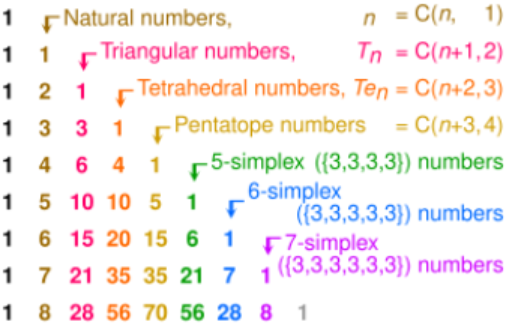

Print out the 6-simplex numbers..

In [18]:
print(np.shape(p))
print(p[p!=0].astype('int64'))

(1, 16, 16, 1)
[   1    6   21   56  126  252  462  792 1287 2002 3003]
